First, we import the necessary libraries for data manipulation, analysis, and visualization.
- `numpy` for numerical operations.
- `pandas` for data loading and manipulation.
- `matplotlib.pyplot` and `seaborn` for creating static visualizations.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We load the transaction data from the "Fraud.csv" file into a pandas DataFrame. We then display the first few rows (`df.head()`) and check the data types and non-null counts of each column (`df.info()`).

In [6]:
df=pd.read_csv("/content/Fraud.csv")
df
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138116 entries, 0 to 138115
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            138116 non-null  int64  
 1   type            138116 non-null  object 
 2   amount          138116 non-null  float64
 3   nameOrig        138116 non-null  object 
 4   oldbalanceOrg   138116 non-null  float64
 5   newbalanceOrig  138116 non-null  float64
 6   nameDest        138116 non-null  object 
 7   oldbalanceDest  138115 non-null  float64
 8   newbalanceDest  138115 non-null  float64
 9   isFraud         138115 non-null  float64
 10  isFlaggedFraud  138115 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 11.6+ MB


We check for any missing values in the DataFrame using `df.isnull().sum()`. This is important for data cleaning and preprocessing before building a machine learning model.

In [7]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


To focus on fraudulent transactions, we create a new DataFrame `fraud_df` by filtering the original DataFrame where the 'isFraud' column is equal to 1. We then display the head, info, and value counts of this filtered DataFrame.

In [8]:
# See only fraudulent transactions
fraud_df = df[df['isFraud'] == 1]

fraud_df.head()
fraud_df.info()
fraud_df.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 2 to 136420
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            122 non-null    int64  
 1   type            122 non-null    object 
 2   amount          122 non-null    float64
 3   nameOrig        122 non-null    object 
 4   oldbalanceOrg   122 non-null    float64
 5   newbalanceOrig  122 non-null    float64
 6   nameDest        122 non-null    object 
 7   oldbalanceDest  122 non-null    float64
 8   newbalanceDest  122 non-null    float64
 9   isFraud         122 non-null    float64
 10  isFlaggedFraud  122 non-null    float64
dtypes: float64(7), int64(1), object(3)
memory usage: 11.4+ KB


step  type      amount      nameOrig     oldbalanceOrg  newbalanceOrig  nameDest     oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
1     CASH_OUT  181.00      C840083671   181.00         0.0             C38997010    21182.00        0.00            1.0      0.0               1
                2806.00     C2101527076  2806.00        0.0             C1007251739  26202.00        0.00            1.0      0.0               1
                20128.00    C1118430673  20128.00       0.0             C339924917   6268.00         12145.85        1.0      0.0               1
                25071.46    C1275464847  25071.46       0.0             C1364913072  9083.76         34155.22        1.0      0.0               1
                35063.63    C1635772897  35063.63       0.0             C1983025922  31140.00        7550.03         1.0      0.0               1
                                                                                                                                               ..
10    TRANSFER  93810.76    C481501970   93810.76       0.0             C1262577882  0.00            0.00            1.0      0.0               1
                503405.88   C1446009472  503405.88      0.0             C2010733400  0.00            0.00            1.0      0.0               1
                2662734.59  C1182702586  2662734.59     0.0             C2143409210  0.00            0.00            1.0      0.0               1
11    CASH_OUT  2100.00     C169099320   2100.00        0.0             C697156329   112512.48       114612.48       1.0      0.0               1
      TRANSFER  2100.00     C785601242   2100.00        0.0             C1576053316  0.00            0.00            1.0      0.0               1
Name: count, Length: 122, dtype: int64

Here, we perform some initial exploratory data analysis to understand the distribution of fraudulent transactions.
1.  **Fraud vs Non-Fraud counts:** A bar plot showing the total counts of fraudulent (1) and non-fraudulent (0) transactions.
2.  **Count of fraud by transaction type:** A bar plot showing the number of fraudulent transactions for each transaction type.
3.  **Compare % fraud within each transaction type:** A bar plot illustrating the percentage of fraudulent transactions within each transaction type.

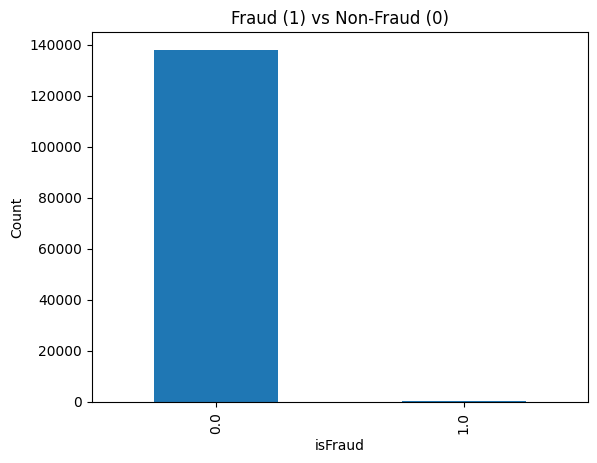

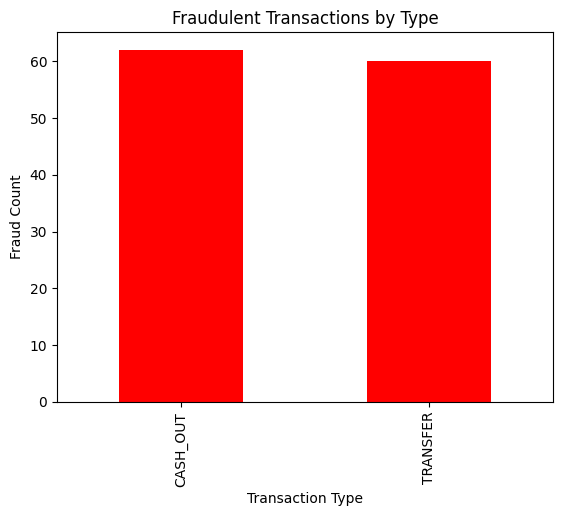

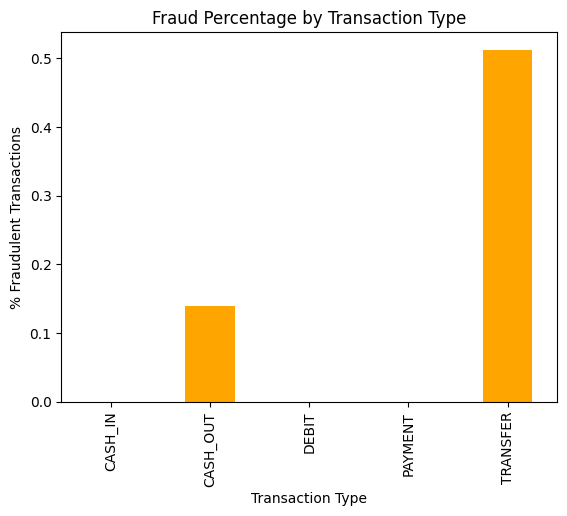

In [9]:
# 1. Fraud vs Non-Fraud counts
df['isFraud'].value_counts().plot(kind='bar', title="Fraud (1) vs Non-Fraud (0)")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

# 2. Count of fraud by transaction type
fraud_by_type = df[df['isFraud'] == 1]['type'].value_counts()
fraud_by_type.plot(kind='bar', title="Fraudulent Transactions by Type", color='red')
plt.xlabel("Transaction Type")
plt.ylabel("Fraud Count")
plt.show()

# 3. Compare % fraud within each transaction type
fraud_ratio = df.groupby('type')['isFraud'].mean() * 100
fraud_ratio.plot(kind='bar', title="Fraud Percentage by Transaction Type", color='orange')
plt.xlabel("Transaction Type")
plt.ylabel("% Fraudulent Transactions")
plt.show()


We engineer two new features to potentially help in fraud detection:
- `errorBalanceOrig`: The difference between the old balance, the transaction amount, and the new balance of the originating account. Ideally, this should be zero for legitimate transactions.
- `errorBalanceDest`: The difference between the old balance, the transaction amount, and the new balance of the destination account. Ideally, this should be zero for legitimate transactions where money is added.

We then display the head of the DataFrame with these new columns to verify their creation.

In [10]:
# Create new error balance features
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

# Quick check
df[['isFraud','errorBalanceOrig','errorBalanceDest']].head()

,isFraud,errorBalanceOrig,errorBalanceDest
0,0.0,0.0,9839.64
1,0.0,0.0,1864.28
2,1.0,0.0,181.00
3,1.0,0.0,21363.00
4,0.0,0.0,11668.14


This code plots the `errorBalanceDest` for both fraudulent and non-fraudulent transactions as line plots. This helps visualize if there's a noticeable difference in the distribution or pattern of balance errors between the two classes.

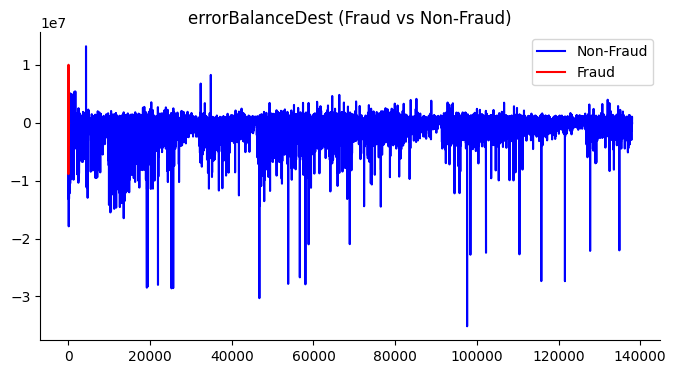

In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,4))

# Non-Fraud (blue)
df[df['isFraud']==0]['errorBalanceDest'].reset_index(drop=True).plot(
    kind='line', label='Non-Fraud', color='blue'
)

# Fraud (red)
df[df['isFraud']==1]['errorBalanceDest'].reset_index(drop=True).plot(
    kind='line', label='Fraud', color='red'
)

plt.title('errorBalanceDest (Fraud vs Non-Fraud)')
plt.legend()
plt.gca().spines[['top','right']].set_visible(False)
plt.show()

This section visualizes the relationship between the transaction amount and whether a transaction is fraudulent, specifically for 'CASH_OUT' transactions, using a scatter plot with Plotly. A linear trendline is also added to observe any general trends.

In [12]:
import plotly.express as px
import plotly.graph_objects as go

cash_out_df = df[df['type'] == 'CASH_OUT']

figure = px.scatter(data_frame=cash_out_df, x='isFraud', y='amount', size='amount', trendline="ols")
figure.show()

We prepare the data for machine learning by separating the features (X) from the target variable (y), which is 'isFraud'. We drop the 'isFraud', 'nameOrig', and 'nameDest' columns from the features as they are either the target or identifiers not suitable for direct use in most models.

In [13]:
# Dependent variable (target)
y = df['isFraud']

# Independent variables (drop IDs)
X = df.drop(columns=['isFraud', 'nameOrig', 'nameDest'])


Here, we set up the data splitting and preprocessing steps for model training.
- We identify categorical ('type') and numerical columns.
- A `ColumnTransformer` is used to apply one-hot encoding to the 'type' column while leaving the numerical columns as they are.
- The data is split into training and testing sets using `train_test_split`, with stratification to maintain the proportion of fraudulent transactions in both sets.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Identify categorical and numeric columns
cat_cols = ['type']
num_cols = [c for c in X.columns if c not in cat_cols]

# Preprocessing: one-hot encode type + keep numeric as is
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

# Drop rows with missing values in the target variable
X_cleaned = X.copy() # Create a copy to avoid modifying the original X
y_cleaned = y.dropna()

# Align indices after dropping rows from y
X_cleaned = X_cleaned.loc[y_cleaned.index]


# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned
)

We build and train a Logistic Regression model using a `Pipeline`. The pipeline first applies the preprocessing steps defined earlier and then trains a `LogisticRegression` model with `class_weight='balanced'` to handle the class imbalance. After training, we make predictions on the test set and evaluate the model's performance using a confusion matrix, classification report, and ROC AUC score.

In [18]:
# Pipeline: preprocessing + logistic regression
log_reg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

log_reg_model.fit(X_train, y_train)

# Predictions
y_pred = log_reg_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC AUC Score:", roc_auc_score(y_test, log_reg_model.predict_proba(X_test)[:,1]))


Confusion Matrix:
 [[26071  1528]
 [    3    21]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9999    0.9446    0.9715     27599
         1.0     0.0136    0.8750    0.0267        24

    accuracy                         0.9446     27623
   macro avg     0.5067    0.9098    0.4991     27623
weighted avg     0.9990    0.9446    0.9707     27623

ROC AUC Score: 0.9401654045436428


This code calculates and displays the feature importances from the Random Forest model. It first fits the preprocessor to get the correct feature names after one-hot encoding and then extracts the importance scores from the trained Random Forest classifier. The top 10 most important features are printed and visualized using a bar plot.

             feature  importance
12  errorBalanceOrig    0.309459
8     newbalanceOrig    0.145444
5               step    0.123717
3       type_PAYMENT    0.096748
9     oldbalanceDest    0.068645
7      oldbalanceOrg    0.062692
4      type_TRANSFER    0.058421
6             amount    0.037274
10    newbalanceDest    0.037011
13  errorBalanceDest    0.023887


/tmp/ipython-input-4210630704.py:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




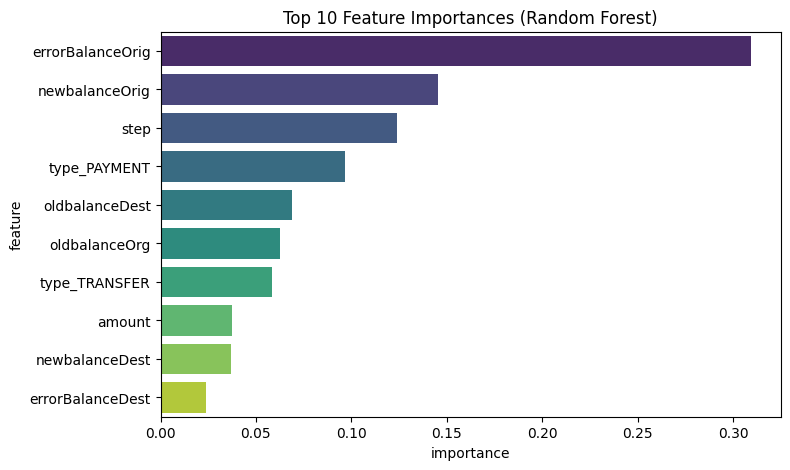

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical and numeric columns
cat_cols = ['type']
num_cols = [c for c in X.columns if c not in cat_cols]

# Preprocessing: one-hot encode type + keep numeric as is
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Get feature names after preprocessing
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = list(cat_features) + num_cols

# Extract importance from Random Forest
importances = rf_model.named_steps['clf'].feature_importances_
feat_imp = pd.DataFrame({'feature': all_features, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

# Show top features
print(feat_imp.head(10))

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline: preprocessing + random forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Train the Random Forest model
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type']),
                                                 ('num', 'passthrough',
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest',
                                                   'isFlaggedFraud',
                                                   'errorBalanceOrig',
                                                   'errorBalanceDest'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

We generate a Precision-Recall curve for the Logistic Regression model. This curve helps visualize the trade-off between precision and recall at different probability thresholds. The Average Precision (AP) score is also calculated and displayed, which summarizes the performance across all thresholds.

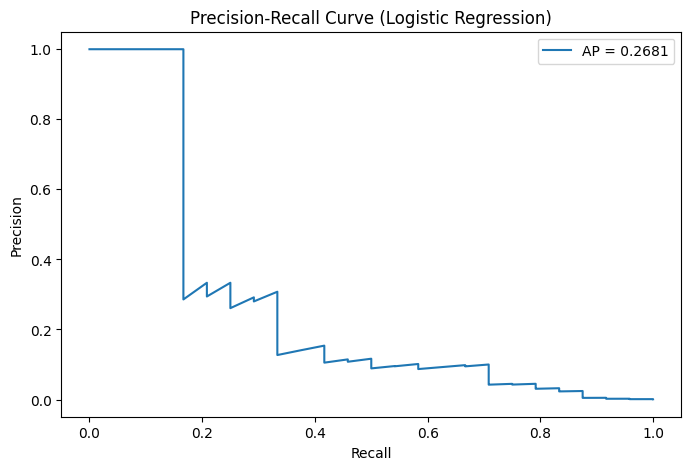

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_scores = log_reg_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8,5))
plt.plot(recall, precision, label=f'AP = {ap:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Logistic Regression)")
plt.legend()
plt.show()


These plots provide further insights into the data:
- **Transaction Amount Distribution (Log Scale):** A box plot showing the distribution of transaction amounts for fraudulent and non-fraudulent transactions, with the y-axis on a log scale to better visualize the spread. Outliers are hidden (`showfliers=False`).
- **Fraudulent Transactions Over Time (Step = Hours):** A line plot showing the count of fraudulent transactions over time, where 'step' represents hours. This helps identify any temporal patterns in fraudulent activity.

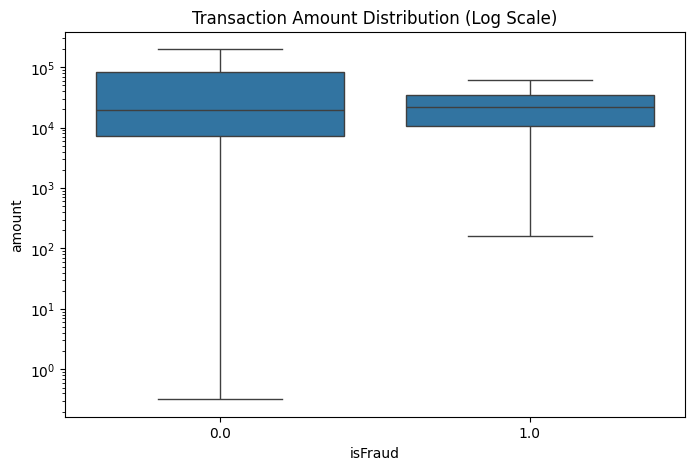

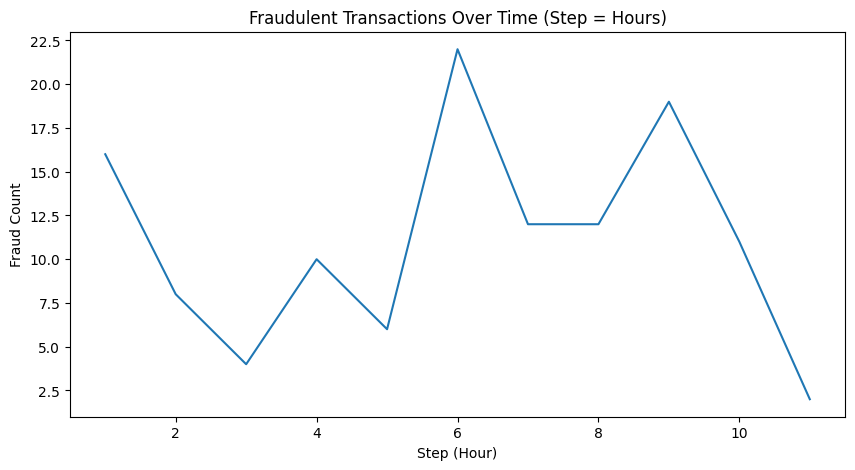

In [23]:
# Fraudulent vs Non-fraud transaction amounts
plt.figure(figsize=(8,5))
sns.boxplot(x='isFraud', y='amount', data=df[df['amount'] < 200000], showfliers=False)
plt.yscale('log')
plt.title("Transaction Amount Distribution (Log Scale)")
plt.show()

# Fraud count by time step
fraud_by_step = df[df['isFraud']==1].groupby('step').size()
fraud_by_step.plot(figsize=(10,5))
plt.title("Fraudulent Transactions Over Time (Step = Hours)")
plt.xlabel("Step (Hour)")
plt.ylabel("Fraud Count")
plt.show()


This notebook explores a dataset of online transactions to detect fraudulent activity. It includes data loading, exploratory data analysis, feature engineering, and machine learning model training for fraud detection.